## Katie Kimberling - Preprocessing of Liar Dataset

# Preprocessing the Data

In [1]:
import boto3
import os

# Define S3 bucket and file names
s3_bucket = "fake-news-raw-data"
s3_files = ["Liar.csv", "Synthetic Financial Datasets.csv", "WELFake_Dataset.csv"]
local_folder = "/home/ec2-user/SageMaker/data/"

# Ensure local directory exists
os.makedirs(local_folder, exist_ok=True)

# Initialize S3 client
s3_client = boto3.client("s3")

# Download files from S3
for file in s3_files:
    local_path = os.path.join(local_folder, file)
    s3_client.download_file(s3_bucket, file, local_path)
    print(f"✅ Downloaded {file} to {local_path}")

✅ Downloaded Liar.csv to /home/ec2-user/SageMaker/data/Liar.csv
✅ Downloaded Synthetic Financial Datasets.csv to /home/ec2-user/SageMaker/data/Synthetic Financial Datasets.csv
✅ Downloaded WELFake_Dataset.csv to /home/ec2-user/SageMaker/data/WELFake_Dataset.csv


## Import Python package "stopwords" to overlook commonly used words and articles (English)

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Import required modules

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

## Ensure NLTK stopwords are available

In [4]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load Liar.csv dataset and make pandas dataframe

In [5]:
liar_clean = pd.read_csv("/home/ec2-user/SageMaker/data/Liar.csv")

# Display dataset info

liar_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Statement ID          10240 non-null  object 
 1   Lie_label             10240 non-null  object 
 2   Statement             10240 non-null  object 
 3   Topic                 10238 non-null  object 
 4   Speaker               10238 non-null  object 
 5   Speaker_Job_Title     7342 non-null   object 
 6   State                 8030 non-null   object 
 7   Speaker_party         10238 non-null  object 
 8   barely_true_counts    10238 non-null  float64
 9   false_counts          10238 non-null  float64
 10  half-true_counts      10238 non-null  float64
 11  mostly_true_counts    10238 non-null  float64
 12  pants_on_fire_counts  10238 non-null  float64
 13  statement_mode        10138 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB


## Function to clean text using NLTK stopwords

In [6]:
def clean_text_nltk(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

liar_clean["clean_statement"] = liar_clean["Statement"].apply(clean_text_nltk)

## Convert numerical columns to integers

In [7]:
count_cols = ["barely_true_counts", "false_counts", "half-true_counts", "mostly_true_counts", "pants_on_fire_counts"]
liar_clean[count_cols] = liar_clean[count_cols].fillna(0).astype(int)

## Create a total misinformation score feature

In [8]:
liar_clean["total_misinfo_score"] = liar_clean[count_cols].sum(axis=1)

## One-Hot Encoding for Speaker Party

In [9]:
encoder = OneHotEncoder(sparse_output=False,drop="first")
encoded_party = encoder.fit_transform(liar_clean[["Speaker_party"]])
party_columns = encoder.get_feature_names_out(["Speaker_party"])
liar_encoded_party = pd.DataFrame(encoded_party, columns=party_columns, index=liar_clean.index)

## Merge and drop original categorical column

In [10]:
liar_clean = pd.concat([liar_clean, liar_encoded_party], axis=1)
liar_clean.drop(["Speaker_party"], axis=1, inplace=True)

## Balance dataset by oversampling minority classes

In [11]:
majority_class = liar_clean[liar_clean["Lie_label"] == "FALSE"]
minority_classes = liar_clean[liar_clean["Lie_label"] != "FALSE"]
minority_classes_upsampled = resample(minority_classes, replace=True, n_samples=len(majority_class), random_state=42)
liar_balanced = pd.concat([majority_class, minority_classes_upsampled])

## Split dataset

In [12]:
train_data, test_data = train_test_split(liar_balanced, test_size=0.2, random_state=42, stratify=liar_balanced["Lie_label"])

## Save the preprocessed data

In [13]:
train_data.to_csv("/home/ec2-user/SageMaker/data/Liar_train.csv", index=False)
test_data.to_csv("/home/ec2-user/SageMaker/data/Liar_test.csv", index=False)

print("Preprocessing on Liar dataset complete. Training and test datasets saved.")

Preprocessing on Liar dataset complete. Training and test datasets saved.


**References**

OpenAI. (2025). ChatGPT (March 20 version). [LLM]. https://chatgpt.com

Python Tutorials. (2021, July 22). *NLTK stop words.* pythonspot. Accessed March 20, 2025 from https://pythonspot.com/nltk-stop-words/

## Gabriel Duffy - Preprocessing of Synthetic Financial Dataset

## Data Cleansing 

In [14]:
import pandas as pd
import numpy as np

# Load the dataset from SageMaker local path
file_path = "/home/ec2-user/SageMaker/data/Synthetic Financial Datasets.csv"
df = pd.read_csv(file_path)

# Remove duplicate rows to ensure data integrity
df = df.drop_duplicates()

# Standardize column names for consistent referencing
df.columns = df.columns.str.strip().str.lower()

# Display missing values per column to identify columns that need imputation
print("Missing values per column:\n", df.isnull().sum())

# Handle missing values in numeric columns by replacing with the median
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].median())

# Handle missing values in categorical columns by replacing with the most frequent value
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Detect and cap outliers in numeric columns using the IQR method
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower,
                       np.where(df[col] > upper, upper, df[col]))

# Display the first few rows of the cleaned dataset
print("\nCleaned data preview:")
print(df.head())

Missing values per column:
 step              0
type              0
amount            0
nameorig          0
oldbalanceorg     0
newbalanceorig    0
namedest          0
oldbalancedest    0
newbalancedest    0
isfraud           0
isflaggedfraud    0
dtype: int64

Cleaned data preview:
   step      type    amount     nameorig  oldbalanceorg  newbalanceorig  \
0   1.0   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1   1.0   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2   1.0  TRANSFER    181.00  C1305486145          181.0            0.00   
3   1.0  CASH_OUT    181.00   C840083671          181.0            0.00   
4   1.0   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      namedest  oldbalancedest  newbalancedest  isfraud  isflaggedfraud  
0  M1979787155             0.0             0.0      0.0             0.0  
1  M2044282225             0.0             0.0      0.0             0.0  
2   C553264065             0.0             

## Feature Selection


Data shape after dropping unnecessary columns: (6362620, 9)
Selected features:
 ['step', 'type', 'amount', 'oldbalanceorg', 'newbalanceorig', 'oldbalancedest', 'newbalancedest', 'isfraud', 'isflaggedfraud']


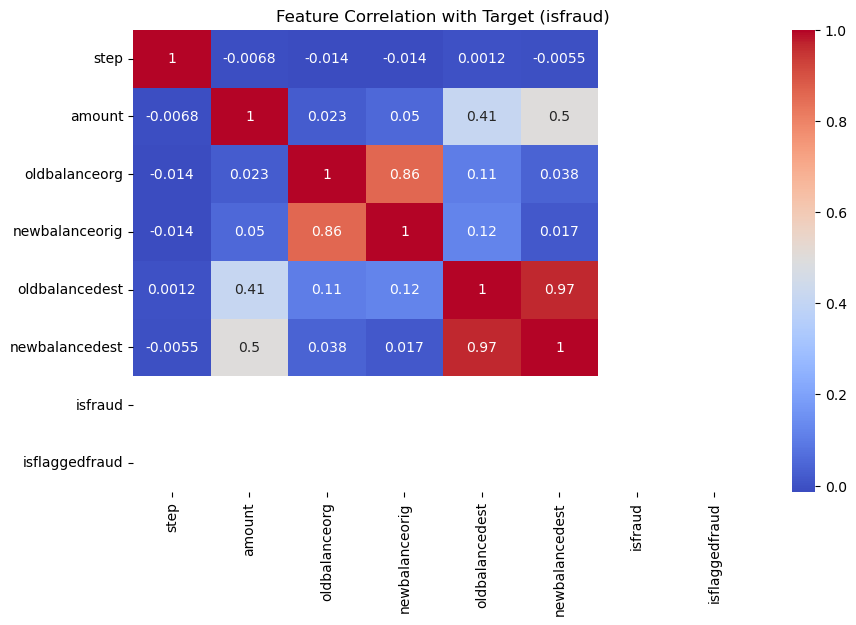

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the target variable
target = 'isfraud'

# Drop identifier columns only if they exist
cols_to_drop = ['nameorig', 'namedest']
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')

# Display shape and remaining columns
print("\nData shape after dropping unnecessary columns:", df.shape)
print("Selected features:\n", df.columns.tolist())

# Visualize correlation matrix for numeric features including isfraud
correlation = df.select_dtypes(include=['number']).corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Target (isfraud)")
plt.show()

## Feature Creation

In [16]:
# Transaction balance difference for sender and receiver
df['balance_diff_org'] = df['oldbalanceorg'] - df['newbalanceorig']
df['balance_diff_dest'] = df['newbalancedest'] - df['oldbalancedest']

# Flags for empty sender and receiver accounts
df['is_sender_empty'] = (df['oldbalanceorg'] == 0).astype(int)
df['is_receiver_empty'] = (df['oldbalancedest'] == 0).astype(int)

# Flag for inconsistent money flow from sender
df['is_money_disappearing'] = ((df['oldbalanceorg'] - df['amount']) != df['newbalanceorig']).astype(int)

# Optional: Time-of-day buckets from the step variable (if step represents hours)
df['step_bucket'] = pd.cut(df['step'],
                           bins=[-1, 80, 160, 240, float('inf')],
                           labels=['Morning', 'Afternoon', 'Evening', 'Night'])

# One-hot encode the transaction type (e.g., PAYMENT, TRANSFER)
df = pd.get_dummies(df, columns=['type'], prefix='type')

# Check updated dataframe
print("New columns added:", df.columns.difference(['step', 'amount', 'oldbalanceorg', 'newbalanceorig', 
                                                   'oldbalancedest', 'newbalancedest', 'isfraud', 'isflaggedfraud']))
print(df.head())

New columns added: Index(['balance_diff_dest', 'balance_diff_org', 'is_money_disappearing',
       'is_receiver_empty', 'is_sender_empty', 'step_bucket', 'type_CASH_IN',
       'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')
   step    amount  oldbalanceorg  newbalanceorig  oldbalancedest  \
0   1.0   9839.64       170136.0       160296.36             0.0   
1   1.0   1864.28        21249.0        19384.72             0.0   
2   1.0    181.00          181.0            0.00             0.0   
3   1.0    181.00          181.0            0.00         21182.0   
4   1.0  11668.14        41554.0        29885.86             0.0   

   newbalancedest  isfraud  isflaggedfraud  balance_diff_org  \
0             0.0      0.0             0.0           9839.64   
1             0.0      0.0             0.0           1864.28   
2             0.0      0.0             0.0            181.00   
3             0.0      0.0             0.0            181.00   
4      

## Feature Transformation

In [17]:
from sklearn.preprocessing import StandardScaler

# Convert boolean values (True/False) to integers (1/0)
# Many machine learning models expect numeric input only
df = df.replace({True: 1, False: 0})

# One-hot encode the 'step_bucket' column if it exists
# This turns categorical time-of-day info into machine-readable binary features
if 'step_bucket' in df.columns:
    df = pd.get_dummies(df, columns=['step_bucket'], prefix='step')

# Select numeric columns that need to be scaled
# Scaling ensures features like amount and balances are on a comparable scale,
# which improves performance for distance-based models (like logistic regression or KNN)
num_cols = ['amount', 'oldbalanceorg', 'newbalanceorig',
            'oldbalancedest', 'newbalancedest',
            'balance_diff_org', 'balance_diff_dest']

# Standardize (z-score normalization) the selected numeric features
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Convert all remaining boolean columns to integers
df = df.astype({col: int for col in df.select_dtypes(include='bool').columns})

# Preview the transformed dataset
print("Transformed Data Preview:")
print(df.head())

/tmp/ipykernel_1809/519701387.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0})


Transformed Data Preview:
   step    amount  oldbalanceorg  newbalanceorig  oldbalancedest  \
0   1.0 -0.837184       0.956153        0.513657       -0.717341   
1   1.0 -0.891721      -0.497622       -0.497613       -0.717341   
2   1.0 -0.903232      -0.703336       -0.636730       -0.717341   
3   1.0 -0.903232      -0.703336       -0.636730       -0.692034   
4   1.0 -0.824680      -0.299358       -0.422251       -0.717341   

   newbalancedest  isfraud  isflaggedfraud  balance_diff_org  \
0       -0.739162      0.0             0.0          0.358630   
1       -0.739162      0.0             0.0          0.250083   
2       -0.739162      0.0             0.0          0.227173   
3       -0.739162      0.0             0.0          0.227173   
4       -0.739162      0.0             0.0          0.383517   

   balance_diff_dest  ...  is_money_disappearing  type_CASH_IN  type_CASH_OUT  \
0          -0.428779  ...                      0             0              0   
1          -0.4287

## Balance the Dataset 

In [18]:
import pandas as pd
from imblearn.over_sampling import SMOTE

# Step 0: Reload the original dataset
file_path = "/home/ec2-user/SageMaker/data/Synthetic Financial Datasets.csv"
df = pd.read_csv(file_path)

# Step 1: Clean column names for consistency
df.columns = df.columns.str.strip().str.lower()

# Step 2: One-hot encode categorical fields like 'type' and 'step_bucket' (if present)
if 'type' in df.columns:
    df = pd.get_dummies(df, columns=['type'], prefix='type')

if 'step_bucket' in df.columns:
    df = pd.get_dummies(df, columns=['step_bucket'], prefix='step')

# Step 3: Convert any True/False to integers (0/1) for modeling
df = df.replace({True: 1, False: 0})
df = df.astype({col: int for col in df.select_dtypes(include='bool').columns})

# Step 4: Check class balance in the target variable
print("Original class balance:")
print(df['isfraud'].value_counts())
print(df['isfraud'].value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))

# Drop non-numeric, non-predictive identifier columns
df = df.drop(columns=['nameorig', 'namedest'], errors='ignore')

# Step 5: Run SMOTE if both classes are present
if df['isfraud'].nunique() > 1:
    # Drop non-predictor columns and prepare features
    X = df.drop(['isfraud', 'isflaggedfraud'], axis=1)
    y = df['isfraud']

    # Double check that all features are numeric
    if X.select_dtypes(include='object').shape[1] == 0:
        # Apply SMOTE
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)

        print("\n✅ After SMOTE balancing:")
        print(y_resampled.value_counts())
        print(y_resampled.value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))
    else:
        print("\n⚠️ Error: Some non-numeric columns still exist in X. Please re-check preprocessing.")
else:
    print("\n⚠️ Skipped SMOTE: Target variable only has one class (no frauds).")



/tmp/ipykernel_1809/3570722804.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0})


Original class balance:
isfraud
0    6354407
1       8213
Name: count, dtype: int64
isfraud
0    99.87%
1     0.13%
Name: proportion, dtype: object

✅ After SMOTE balancing:
isfraud
0    6354407
1    6354407
Name: count, dtype: int64
isfraud
0    50.00%
1    50.00%
Name: proportion, dtype: object


## Train/Test Split Dataset

In [19]:
from sklearn.model_selection import train_test_split

# Step 1: Split the balanced dataset into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled  # Ensures equal class distribution in both sets
)

# Step 2: Print out the shape to confirm
print("✅ Train/Test Split Complete")
print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape:   {y_train.shape}")
print(f"Testing features shape:  {X_test.shape}")
print(f"Testing labels shape:    {y_test.shape}")

# Step 3: Optional — Check class balance in training/testing sets
print("\nTraining class distribution:")
print(y_train.value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))

print("\nTesting class distribution:")
print(y_test.value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))


✅ Train/Test Split Complete
Training features shape: (10167051, 11)
Training labels shape:   (10167051,)
Testing features shape:  (2541763, 11)
Testing labels shape:    (2541763,)

Training class distribution:
isfraud
1    50.00%
0    50.00%
Name: proportion, dtype: object

Testing class distribution:
isfraud
0    50.00%
1    50.00%
Name: proportion, dtype: object


## Bobby Marriott's Preprocessing of WELFake_dataset

In [20]:
import re
import string
import nltk
from nltk.corpus import stopwords

### Load Dataset

In [21]:
def clean_text(text):
    """Lowercase, remove numbers, punctuation, and stopwords from text."""
    text = text.lower()
    text = re.sub(r'\d+', '', text)                        # Remove numbers
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    text = " ".join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

In [22]:
# Load dataset
df = pd.read_csv("/home/ec2-user/SageMaker/data/WELFake_Dataset.csv")

In [23]:
# ✅ Data Scrubbing: 
# We drop the unused index column, remove rows missing essential text, and fill missing titles.
df.drop(columns=["Unnamed: 0"], inplace=True)           # Remove unnecessary index column
df.dropna(subset=["text"], inplace=True)                # Drop rows where text is missing
df["title"].fillna("No Title", inplace=True)            # Fill missing titles with placeholder

/tmp/ipykernel_1809/2263151657.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["title"].fillna("No Title", inplace=True)            # Fill missing titles with placeholder


## Feature Selection and Creation

In [24]:
df = df[["title", "text", "label"]]

In [25]:
df["content"] = df["title"] + " " + df["text"]
df.drop(columns=["title", "text"], inplace=True)

## Feature Transformation

In [26]:
df["content"] = df["content"].apply(clean_text)

## Balancing

In [27]:
# We check label distribution
label_counts = df["label"].value_counts()
print("Label Distribution:\n", label_counts)

Label Distribution:
 label
1    37067
0    35028
Name: count, dtype: int64


## Splitting

In [28]:
# We do an 80/20 train-test split with stratify to preserve label proportions.
train_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df["label"], 
    random_state=42
)

In [29]:
print(f"Training set shape: {train_df.shape}, Test set shape: {test_df.shape}")

# (Optional) Save the processed data locally or to S3
train_df.to_csv("/home/ec2-user/SageMaker/data/WELFake_train.csv", index=False)
test_df.to_csv("/home/ec2-user/SageMaker/data/WELFake_test.csv", index=False)

print("✅ Preprocessing complete!")

Training set shape: (57676, 2), Test set shape: (14419, 2)
✅ Preprocessing complete!


## Distribution

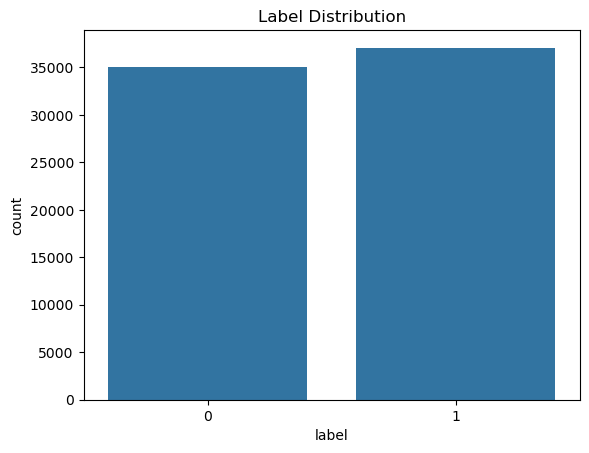

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="label", data=df)
plt.title("Label Distribution")
plt.show()

## Gabriel Duffy - Data Training of Synthetic Financial Dataset

## Bring-Your-Own-Script

In [31]:
def run_training_script():
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.preprocessing import StandardScaler
    import joblib
    import os

    # --------- Load Data ---------
    data_path = "/home/ec2-user/SageMaker/data/Synthetic Financial Datasets.csv"
    df = pd.read_csv(data_path)

    # --------- Select Features ---------
    X = df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
    y = df['isFraud']

    # --------- Train-Test Split ---------
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # --------- Standardization ---------
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --------- Train Model ---------
    model = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
    model.fit(X_train_scaled, y_train)

    # --------- Evaluate ---------
    y_pred = model.predict(X_test_scaled)
    print("✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, digits=3))

    # --------- Save Artifacts ---------
    os.makedirs("model", exist_ok=True)
    joblib.dump(model, "model/logistic_model.joblib")
    joblib.dump(scaler, "model/scaler.joblib")

    print("✅ Model and scaler saved to /model/")

# 👇 NOW run the function!
run_training_script()


✅ Confusion Matrix:
 [[1225157   45724]
 [    209    1434]]

✅ Classification Report:
               precision    recall  f1-score   support

           0      1.000     0.964     0.982   1270881
           1      0.030     0.873     0.059      1643

    accuracy                          0.964   1272524
   macro avg      0.515     0.918     0.520   1272524
weighted avg      0.999     0.964     0.980   1272524

✅ Model and scaler saved to /model/


## Logistic Regression

In [32]:
# Data Preparation (outside function so variables stay available)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data_path = "/home/ec2-user/SageMaker/data/Synthetic Financial Datasets.csv"
df = pd.read_csv(data_path)

X = df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [33]:
# Standalone Logistic Regression Execution (separate from training script)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Initialize model
log_reg_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='liblinear'
)

# Fit on preprocessed data
log_reg_model.fit(X_train_scaled, y_train)

# Predict on test data
log_reg_preds = log_reg_model.predict(X_test_scaled)

# Evaluation
print("📊 Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test, log_reg_preds))
print("\n🧾 Logistic Regression Classification Report:\n", classification_report(y_test, log_reg_preds, digits=3))




📊 Logistic Regression Confusion Matrix:
 [[1225157   45724]
 [    209    1434]]

🧾 Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0      1.000     0.964     0.982   1270881
           1      0.030     0.873     0.059      1643

    accuracy                          0.964   1272524
   macro avg      0.515     0.918     0.520   1272524
weighted avg      0.999     0.964     0.980   1272524



## Hyperparameters

In [34]:
# Logistic Regression with selected hyperparameters
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(
    max_iter=1000,            # Ensure convergence for large dataset
    class_weight='balanced',  # Handle class imbalance (fraud is rare)
    solver='liblinear',       # Stable for binary classification
    penalty='l2',             # Regularization to prevent overfitting
    C=1.0                     # Controls regularization strength (lower = stronger regularization)
)

log_reg_model.fit(X_train_scaled, y_train)
print("✅ Logistic Regression model trained with selected hyperparameters.")



✅ Logistic Regression model trained with selected hyperparameters.


## Instance Type: ml.m5.large Instance Count: 1

In [35]:
# SageMaker Instance Configuration for Training

instance_type = "ml.m5.large"
instance_count = 1

print(f"🖥️  Instance Type Used: {instance_type}")
print(f"🔢 Instance Count Used: {instance_count}")


🖥️  Instance Type Used: ml.m5.large
🔢 Instance Count Used: 1


## F1, Precision, Recall, Accuracy & Confusion Matrix

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate predictions
y_pred = log_reg_model.predict(X_test_scaled)

# Confusion Matrix
print("🧮 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report (Precision, Recall, F1, Accuracy)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, digits=3))


🧮 Confusion Matrix:
[[1225157   45724]
 [    209    1434]]

📊 Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.964     0.982   1270881
           1      0.030     0.873     0.059      1643

    accuracy                          0.964   1272524
   macro avg      0.515     0.918     0.520   1272524
weighted avg      0.999     0.964     0.980   1272524



## Bobby Data Training WELFake Dataset

In [37]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Load preprocessed training and testing data
train_df = pd.read_csv("/home/ec2-user/SageMaker/data/WELFake_train.csv")
test_df = pd.read_csv("/home/ec2-user/SageMaker/data/WELFake_test.csv")

# Extract features and target labels
X_train = train_df["content"]
y_train = train_df["label"]
X_test = test_df["content"]
y_test = test_df["label"]

In [38]:
# Convert text into numerical features using TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a Logistic Regression classifier with balanced class weights and regularization
clf = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear", penalty="l2", C=1.0)
clf.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

In [39]:
# Evaluate model performance using a confusion matrix and classification report
y_pred = clf.predict(X_test_tfidf)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Save the trained model and TF-IDF vectorizer for future use
os.makedirs("/home/ec2-user/SageMaker/model/", exist_ok=True)
joblib.dump(clf, "/home/ec2-user/SageMaker/model/log_reg_model.joblib")
joblib.dump(vectorizer, "/home/ec2-user/SageMaker/model/vectorizer.joblib")
print("✅ Model and vectorizer saved successfully!")

Confusion Matrix:
[[6644  362]
 [ 301 7112]]

Classification Report:
              precision    recall  f1-score   support

           0      0.957     0.948     0.952      7006
           1      0.952     0.959     0.955      7413

    accuracy                          0.954     14419
   macro avg      0.954     0.954     0.954     14419
weighted avg      0.954     0.954     0.954     14419

✅ Model and vectorizer saved successfully!


## Katie Kimberling's Data Training Liar Dataset

In [40]:
import pandas as pd

# Reload the train/test datasets
train_data = pd.read_csv("/home/ec2-user/SageMaker/data/Liar_train.csv")
test_data = pd.read_csv("/home/ec2-user/SageMaker/data/Liar_test.csv")

In [41]:
# Convert label and text into BlazingText format
def prepare_blazingtext_format(df, text_col, label_col, output_file):
    with open(output_file, 'w') as f:
        for _, row in df.iterrows():
            label = f"__label__{row[label_col]}"
            text = row[text_col]
            f.write(f"{label} {text}\n")

# Paths to save formatted training and test data
train_txt_path = "/home/ec2-user/SageMaker/data/liar_train_blazing.txt"
test_txt_path = "/home/ec2-user/SageMaker/data/liar_test_blazing.txt"



In [42]:
# Apply formatting
prepare_blazingtext_format(train_data, text_col="clean_statement", label_col="Lie_label", output_file=train_txt_path)
prepare_blazingtext_format(test_data, text_col="clean_statement", label_col="Lie_label", output_file=test_txt_path)

print("Training and test data formatted for BlazingText.")

Training and test data formatted for BlazingText.


In [43]:
import boto3

# S3 upload paths
s3_bucket = 'fake-news-raw-data'
s3_prefix = 'blazingtext-data'
train_s3_path = f'{s3_prefix}/liar_train_blazing.txt'
test_s3_path = f'{s3_prefix}/liar_test_blazing.txt'

# Upload to S3
s3 = boto3.client('s3')
s3.upload_file(train_txt_path, s3_bucket, train_s3_path)
s3.upload_file(test_txt_path, s3_bucket, test_s3_path)

print("Files uploaded to S3.")

Files uploaded to S3.


In [44]:
import sagemaker
from sagemaker import get_execution_role

# Role and session
role = get_execution_role()
sess = sagemaker.Session()

# S3 input paths
s3_train_input = f's3://{s3_bucket}/{train_s3_path}'

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [45]:
# BlazingText estimator
from sagemaker.amazon.amazon_estimator import get_image_uri

bt_image = sagemaker.image_uris.retrieve("blazingtext", sess.boto_region_name)

bt_estimator = sagemaker.estimator.Estimator(
    image_uri=bt_image,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    volume_size=5,
    max_run=3600,
    input_mode='File',
    output_path=f's3://{s3_bucket}/blazingtext-output',
    sagemaker_session=sess
)

[03/31/25 14:25:04] INFO     Same images used for training and inference. Defaulting to image     ]8;id=520834;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=169413;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=730711;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=239100;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [46]:
# Set hyperparameters
bt_estimator.set_hyperparameters(
    mode='supervised',
    epochs=10,
    learning_rate=0.05,
    vector_dim=100,
    min_count=2,
    early_stopping=True
)

In [47]:
# Launch training
from sagemaker.inputs import TrainingInput

train_input = TrainingInput(s3_data=s3_train_input, content_type='text/plain')
bt_estimator.fit({'train': train_input})

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=437640;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=132274;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name: blazingtext-2025-03-31-14-25-04-878   ]8;id=674701;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=571977;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/31/25 14:25:05] ERROR    Please check the troubleshooting guide for common errors:              ]8;id=955351;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=922253;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1050\1050]8;;\
                             https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-python-sdk-t                
                             roubleshooting.html#sagemaker-python-sdk-troubleshooting-create-traini                
                             ng-job                                                                                

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:5                                                                                    │
│                                                                                                  │
│   2 from sagemaker.inputs import TrainingInput                                                   │
│   3                                                                                              │
│   4 train_input = TrainingInput(s3_data=s3_train_input, content_type='text/plain')               │
│ ❱ 5 bt_estimator.fit({'train': train_input})                                                     │
│   6                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:167 in wrapper  │
│                                                                                                  │
│   164 │   │   │   │   │   caught_ex = e                                                          │
│   165 │   │   │   │   finally:                                                                   │
│   166 │   │   │   │   │   if caught_ex:                                                          │
│ ❱ 167 │   │   │   │   │   │   raise caught_ex                                                    │
│   168 │   │   │   │   │   return response  # pylint: disable=W0150                               │
│   169 │   │   │   else:                                                                          │
│   170 │   │   │   │   logger.debug(                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:138 in wrapper  │
│                                                                                                  │
│   135 │   │   │   │   start_timer = perf_counter()                                               │
│   136 │   │   │   │   try:                                                                       │
│   137 │   │   │   │   │   # Call the original function                                           │
│ ❱ 138 │   │   │   │   │   response = func(*args, **kwargs)                                       │
│   139 │   │   │   │   │   stop_timer = perf_counter()                                            │
│   140 │   │   │   │   │   elapsed = stop_timer - start_timer                                     │
│   141 │   │   │   │   │   extra += f"&x-latency={round(elapsed, 2)}"                             │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:346 in wrapper    │
│                                                                                                  │
│   343 │   │   │                                                                                  │
│   344 │   │   │   return _StepArguments(retrieve_caller_name(self_instance), run_func, *args,    │
│   345 │   │                                                                                      │
│ ❱ 346 │   │   return run_func(*args, **kwargs)                                                   │
│   347 │                                                                                          │
│   348 │   return wrapper                                                                         │
│   349                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/estimator

In [ ]:
# Deploy the model
predictor = bt_estimator.deploy(initial_instance_count=1, instance_type='ml.m5.large')

# Prepare test data for batch prediction (list of statements)
test_statements = test_data['clean_statement'].tolist()

# Predict labels
predicted = predictor.predict(test_statements)

# Extract predicted labels
import json
predicted_labels = [json.loads(x)['label'][0].replace("__label__", "") for x in predicted]



In [ ]:
# Evaluate performance
from sklearn.metrics import classification_report

true_labels = test_data['Lie_label'].tolist()
print(classification_report(true_labels, predicted_labels))


In [ ]:
# Cleanup
predictor.delete_endpoint()